# MODEL 1

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage import io
import cv2
import random

import tensorflow as tf
'''from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import add
from keras.layers import Activation
from keras.layers import UpSampling2D
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Lambda
from keras.layers import multiply
from keras.layers import concatenate'''

from tensorflow.keras import backend as K
from tensorflow.keras.metrics import MeanIoU


In [ ]:
import dataset
mySet=dataset.Dataset("/content/drive/MyDrive/Intercubic","TrainingSet","TestSet","Segmentation")

['/content/drive/MyDrive/Intercubic/TrainingSet/Image', '/content/drive/MyDrive/Intercubic/TestSet/Image']


In [ ]:
mySet.importSegmentationClass(False)

In [ ]:
mySet.trainingArrayX=mySet.trainingArrayX.astype('float32')
mySet.trainingArrayY=mySet.trainingArrayY.astype('float32')
mySet.testArrayX=mySet.testArrayX.astype('float32')
mySet.testArrayY=mySet.testArrayY.astype('float32')

In [ ]:

for i in range(len(mySet.trainingArrayX)):
  mySet.trainingArrayX[i]=mySet.trainingArrayX[i]/255.
  mySet.trainingArrayY[i]=mySet.trainingArrayY[i]/255.
  '''trainlistx.append(cv2.resize(mySet.trainingArrayX[i],(256,256),0,0,interpolation = cv2.INTER_NEAREST))
  trainlisty.append(cv2.resize(mySet.trainingArrayY[i],(256,256),0,0,interpolation= cv2.INTER_NEAREST))
  '''

In [ ]:
for i in range(len(mySet.testArrayX)):
  mySet.testArrayX[i]=mySet.testArrayX[i]/255.
  mySet.testArrayY[i]=mySet.testArrayY[i]/255.
  '''testlistx.append(cv2.resize(mySet.testArrayX[i],(256,256),0,0,interpolation = cv2.INTER_NEAREST))
  testlisty.append(cv2.resize(mySet.testArrayY[i],(256,256),0,0,interpolation= cv2.INTER_NEAREST))'''

In [ ]:
!nvidia-smi

Thu Sep 23 10:32:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
number=3

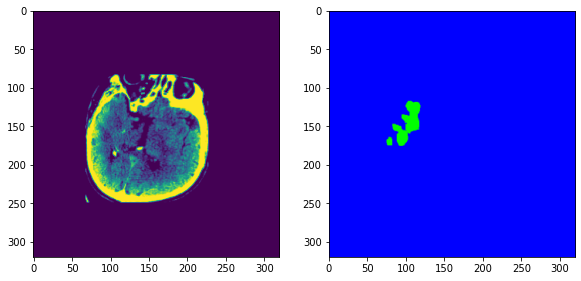

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15,15))
plt.subplot(231)
plt.imshow(mySet.trainingArrayX[number])
plt.subplot(232)
plt.imshow(mySet.trainingArrayY[number])
number+=1

     |████████████████████████████████| 9.4 MB 13.9 MB/s 


In [ ]:
mySet.trainingArrayX.shape,mySet.trainingArrayY.shape,mySet.testArrayX.shape,mySet.testArrayY.shape

((8840, 256, 256), (8840, 256, 256, 3), (441, 256, 256), (441, 256, 256, 3))

In [ ]:
from skimage.transform import resize

trainlistx,trainlisty=[],[]
for i in range(len(mySet.trainingArrayX)):
  trainlistx.append(resize(mySet.trainingArrayX[i],(256,256)))
  trainlisty.append(resize(mySet.trainingArrayY[i],(256,256)))

In [ ]:
import numpy as np
trainingArrayX=np.array(trainlistx)
del trainlistx
trainingArrayY=np.array(trainlisty)
del trainlisty

In [ ]:
testlistx,testlisty=[],[]
for i in range(len(mySet.testArrayX)):
  testlistx.append(resize(mySet.testArrayX[i],(256,256)))
  testlisty.append(resize(mySet.testArrayY[i],(256,256)))

In [ ]:
testArrayX=np.array(testlistx)
del testlistx
testArrayY=np.array(testlisty)
del testlisty

In [ ]:
trainingArrayX.shape,trainingArrayY.shape,testArrayX.shape,testArrayY.shape

In [ ]:
del mySet

In [ ]:
import numpy as np
import tensorflow as tf
smooth=100
# loss function and metrics
def dice_coef(y_pred, Y):
    y_flatten = K.flatten(Y)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_flatten * y_pred_flatten)
    dice = (0.2 * intersection + 1.0) / (K.sum(y_flatten) + K.sum(y_pred_flatten) + 1.0)
    return dice

def jacard_coef(y_pred, Y):
    y_flatten = K.cast(K.flatten(Y[0,:,:,0:2]),tf.int8)
    y_pred_flatten = K.cast(K.flatten(y_pred[0,:,:,0:2]),tf.int8)
    intersection = K.sum(y_flatten * y_pred_flatten)
    y_flatten_bool=K.cast(y_flatten,tf.bool)
    y_pred_flatten_bool=K.cast(y_pred_flatten,tf.bool)
    xor=K.sum(K.cast(tf.math.logical_xor(y_flatten_bool,y_pred_flatten_bool),tf.int8))
    iou=intersection/(intersection+xor)
    return iou

def jacard_coef_loss(y_pred, Y):
    return 1-jacard_coef(y_pred, Y)


def dice_coef_loss(y_pred, Y):
    return -dice_coef(y_pred, Y)
  
def iou(y_pred, y_true):

    y_pred=K.flatten(y_pred)
    y_true=K.flatten(y_true)
    intersection=tf.keras.backend.any(tf.keras.backend.stack([y_pred, y_true], axis=0), axis=0)
    union=tf.keras.backend.all(tf.keras.backend.stack([y_pred, y_true], axis=0), axis=0)
    intersection = K.cast(intersection,"int32")
    union=K.cast(union,"int32")
    '''intersection=K.logical_and(y_pred[0:2],y_true[0:2])
    union=K.logical_or(y_pred[0:2],y_true[0:2])'''
    iou=K.sum(intersection)/K.sum(union)
    return iou
  

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2])
  union = K.sum(y_true,[1,2])+K.sum(y_pred,[1,2])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou


In [ ]:
def mean_iou(y_pred, y_true):
  y_pred=K.flatten(y_pred)
  y_true=K.flatten(y_true)
  diffOne=tf.math.not_equal(y_pred[0,:,:,0],0)
  diffTwo=tf.math.not_equal(y_true[0,:,:,0],0)
  diff=K.cast(tf.math.equal(diffOne,diffTwo),tf.int8)
  neg=K.cast(tf.math.not_equal(y_pred[0,:,:,0],y_true[0,:,:,0]),tf.int8)

  diffOneTwo=tf.math.not_equal(y_pred[0,:,:,1],0)
  diffTwoTwo=tf.math.not_equal(y_true[0,:,:,1],0)
  diffTwo=K.cast(tf.math.equal(diffOneTwo,diffTwoTwo),tf.int8)
  negTwo=K.cast(tf.math.not_equal(y_pred[0,:,:,1],y_true[0,:,:,1]),tf.int8)

  int1=K.sum(diff)/(K.sum(diff)+K.sum(neg))
  int2=K.sum(diffTwo)/(K.sum(diffTwo)+K.sum(negTwo))
  print(int1,int2)
  return (int1+int2)/2
  

In [ ]:
import attenunet

In [ ]:
unet_model = attenunet.Attention_UNet((256,256,3),num_classes=3,dropout=0.2)
att_unet_model = unet_model.build_attention_unit()

Model: "Attention_UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
_____________________________________________________________________________________

In [ ]:
tf.keras.utils.plot_model(att_unet_model)

In [ ]:
att_unet_model.load_weights("/content/drive/MyDrive/SegmentationNewModels/HighestmodelFifth.h5")

In [ ]:
focal_loss = sm.losses.CategoricalCELoss()

adam=tf.keras.optimizers.Adam()
metric = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
att_unet_model.compile(loss=focal_loss, optimizer=adam, 
              metrics=metric)

In [ ]:
checkpoint_filepath="/content/drive/MyDrive/attUnetModels/mehakif.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_iou_score',
    mode='max',
    save_best_only=True)



In [ ]:
history = att_unet_model.fit(mySet.trainingArrayX, mySet.trainingArrayY, 
                             verbose=1,
                             batch_size = 8,
                             validation_data=(mySet.testArrayX,mySet.testArrayY),
                             shuffle=False,
                             epochs=25,
                             callbacks=[model_checkpoint_callback])

In [ ]:
att_unet_model.evaluate(mySet.testArrayX,mySet.testArrayY,verbose=1)

14/14 [==============================] - 4s 207ms/step - loss: 0.0590 - dice_coef: 0.9904 - jacard_coef: -0.1820


[0.05901692807674408, 0.9904336333274841, -0.18195804953575134]

In [ ]:
num_img_test = 0

In [ ]:
from skimage.transform import resize

img=cv2.imread("/content/drive/MyDrive/NewDatasetsBG/Bone/TestSet/No/10100.png")
img=img.astype(np.float32)
img/=255.
img=resize(img,(256,256))
img=img.reshape(1,256,256,3)

In [ ]:
att_unet_model1 = unet_model.build_attention_unit()
att_unet_model1.load_weights("/content/drive/MyDrive/SegmentationNewModels/HighestmodelOne.h5")
att_unet_model2 = unet_model.build_attention_unit()
att_unet_model2.load_weights("/content/drive/MyDrive/SegmentationNewModels/HighestmodelTwo.h5")
att_unet_model3 = unet_model.build_attention_unit()
att_unet_model3.load_weights("/content/drive/MyDrive/SegmentationNewModels/HighestmodelThree.h5")
att_unet_model4 = unet_model.build_attention_unit()
att_unet_model4.load_weights("/content/drive/MyDrive/SegmentationNewModels/HighestmodelFour.h5")
att_unet_model5 = unet_model.build_attention_unit()
att_unet_model5.load_weights("/content/drive/MyDrive/SegmentationNewModels/HighestmodelFifth.h5")


In [ ]:
num_img_test=0

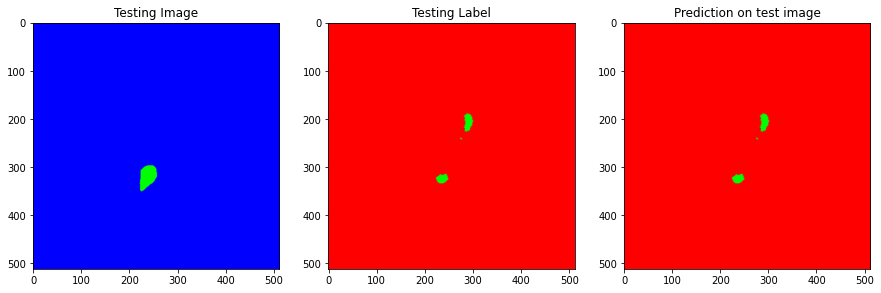

In [ ]:

img_test = cv2.imread("/content/drive/MyDrive/Segment/BoneNewTwo/TestSet/Annotation/"+mySet.nameArray[num_img_test])
test_label = cv2.resize(cv2.imread("/content/testFolder/"+mySet.nameArray[num_img_test]),(512,512),interpolation=cv2.INTER_CUBIC)

img_test_input = np.expand_dims(img_test, 0)

#pred = ((model.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8)
'''pred2 = ((att_unet_model2.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8)
pred3 = ((att_unet_model3.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8)
pred4 = ((att_unet_model4.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8)
pred5 = ((att_unet_model5.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8)'''
#pred = (att_unet_model.predict(img_test_input)[0,:,:,0] > 0.5).astype(np.uint8)
#pred2 = (att_unet_model.predict(img_test_input)[0,:,:,1] > 0.5).astype(np.uint8)
# Visualize the result 
plt.figure(figsize=(15, 10))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(img_test, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_label, cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_label, cmap='gray')


num_img_test+=1


In [ ]:
from matplotlib import pyplot as plt
plt.imsave("perd4.png",cv2.cvtColor(pred4,cv2.COLOR_BGR2RGB))

NameError: ignored

In [ ]:
import cv2

In [ ]:
for i in range(len(mySet.nameArray)):
  img_test = mySet.testArrayX[i]
  img_test_input = np.expand_dims(img_test, 0)
  plt.imsave("/content/testFolder/"+str(mySet.nameArray[i]),cv2.cvtColor(((model.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8),cv2.COLOR_BGR2RGB))

In [ ]:
!zip -r "/content/testFolder.zip" "/content/testFolder"

In [ ]:
target=res
prediction=resized
intersection = np.logical_and(target, prediction)
union = np.logical_or(target, prediction)
iou_score = np.sum(intersection) / np.sum(union)

In [ ]:
iou_score

# Model 2

In [ ]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [ ]:
multiunet=multi_unet_model(3,512,512)

In [ ]:
newmulti=multi_unet_model(3,512,512,3)

In [ ]:
newmulti.load_weights("/content/drive/MyDrive/sotaSegMod/model2w.h5")

In [ ]:
multiunet.summary()

In [ ]:
multiunet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',jacard_coef])

In [ ]:
checkpoint_filepath="/content/drive/MyDrive/sotaSegMod/modelgrayscaleNEWMODEL2.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_jacard_coef',
    mode='max',
    save_weights_only=True,
    save_best_only=True)

In [ ]:
history = multiunet.fit(mySet.trainingArrayX, mySet.trainingArrayY, 
                             verbose=1,
                             batch_size = 16,
                             validation_data=(mySet.testArrayX,mySet.testArrayY),
                             shuffle=False,
                             epochs=200,
                             callbacks=[model_checkpoint_callback])

In [ ]:
multiunet.evaluate(mySet.testArrayX,mySet.testArrayY)

In [ ]:
for i in range(len(mySet.nameArray)):
  img_test = mySet.testArrayX[i]
  img_test_input = np.expand_dims(img_test, 0)
  plt.imsave("/content/testFolder/"+str(mySet.nameArray[i]),(((model.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8)))

In [ ]:
num_img_test=0

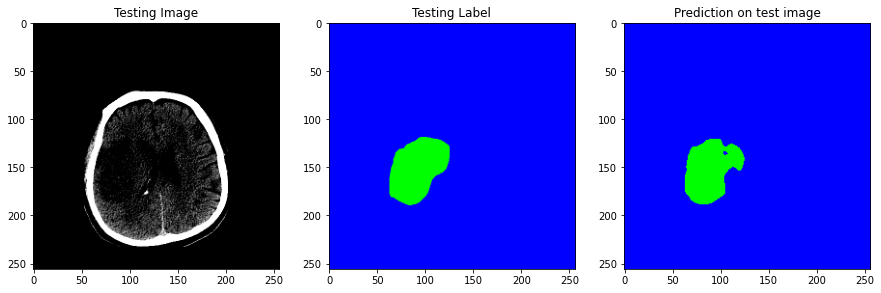

In [ ]:

img_test = mySet.testArrayX[num_img_test]
test_label = mySet.testArrayY[num_img_test]

img_test_input = np.expand_dims(img_test, 0)

pred = ((model.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8)
'''pred2 = ((att_unet_model2.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8)
pred3 = ((att_unet_model3.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8)
pred4 = ((att_unet_model4.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8)
pred5 = ((att_unet_model5.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8)'''
#pred = (att_unet_model.predict(img_test_input)[0,:,:,0] > 0.5).astype(np.uint8)
#pred2 = (att_unet_model.predict(img_test_input)[0,:,:,1] > 0.5).astype(np.uint8)
# Visualize the result 
plt.figure(figsize=(15, 10))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(img_test, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_label[:,:,:], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(pred, cmap='gray')


num_img_test+=1


# MODEL 3


In [ ]:
IMAGE_SIZE = 512
EPOCHS = 30
BATCH = 8
LR = 1e-4

PATH = "/content/"

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

In [ ]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(3, (1, 1), padding="same")(x)
    x = Activation("softmax")(x)
    
    model = Model(inputs, x)
    return model

In [ ]:
modelim=model()
modelim.summary()

In [ ]:
modelim.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',jacard_coef])

In [ ]:
checkpoint_filepath="/content/drive/MyDrive/SegmentationNewModels/modelim22.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_jacard_coef',
    mode='max',
    save_best_only=True)

In [ ]:
history = modelim.fit(mySet.trainingArrayX, mySet.trainingArrayY, 
                             verbose=1,
                             batch_size = 4,
                             validation_data=(mySet.testArrayX,mySet.testArrayY),
                             shuffle=False,
                             epochs=50,
                             callbacks=[model_checkpoint_callback])

# MODEL 4


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg16_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg16.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg16.get_layer("block3_conv3").output         ## (128 x 128)
    s4 = vgg16.get_layer("block4_conv3").output         ## (64 x 64)

    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(3, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model

In [ ]:
model = build_vgg16_unet((256,256,3))
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',jacard_coef])

In [ ]:
checkpoint_filepath="/content/drive/MyDrive/SegmentationNewModels/vgg16unet.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_jacard_coef',
    mode='max',
    save_best_only=True)

In [ ]:
history = model.fit(mySet.trainingArrayX, mySet.trainingArrayY, 
                             verbose=1,
                             batch_size = 16,
                             validation_data=(mySet.testArrayX,mySet.testArrayY),
                             shuffle=False,
                             epochs=50,
                             callbacks=[model_checkpoint_callback])

# MODEL 5


In [ ]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.layers import *
#from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
input_height=256
input_width=256
n_classes=3
VGG_Weights_path="/content/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
def FCN8(IMG_input, nClasses,  input_height=224, input_width=224):
    ## input_height and width must be devisible by 32 because maxpooling with filter size = (2,2) is operated 5 times,
    ## which makes the input_height and width 2^5 = 32 times smaller   
    ## Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(IMG_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    f1 = x
    
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    pool3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)## (None, 14, 14, 512) 

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(pool4)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)## (None, 7, 7, 512)
     
    vgg  = Model(img_input, pool5)
    vgg.load_weights(VGG_Weights_path) ## loading VGG weights for the encoder parts of FCN8
    
    o = (Conv2D(n_classes, (7, 7), activation='relu', padding='same', name="conv6"))(pool5)
        
    ## 4 times upsamping for final layer
    conv6_4 = Conv2DTranspose(n_classes, kernel_size=(4,4),  strides=(4,4), use_bias = False)(o)
    ## 2 times upsampling for pool411
    pool4_n = ( Conv2D(n_classes, (1, 1), activation='relu', padding='same', name="pool4_n"))(pool4)
    pool4_n_2 = (Conv2DTranspose(nClasses, kernel_size=(2,2), strides=(2,2), use_bias=False))(pool4_n)
    #1 time for pool3
    pool3_n = (Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool3_n"))(pool3)
        
    o = Add(name="add")([pool4_n_2, pool3_n, conv6_4 ])
    o = Conv2DTranspose( nClasses , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False)(o)
    o = (Activation('softmax'))(o)
    
    model = Model(img_input, o)
    return model

img_input = Input(shape=(input_height,input_width, 3)) 
model = FCN8(img_input,n_classes,  
             input_height = 224, 
             input_width = 224)
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',jacard_coef])

In [ ]:
checkpoint_filepath="/content/drive/MyDrive/SegmentationNewModels/fcnmodel.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_jacard_coef',
    mode='max',
    save_best_only=True)

In [ ]:
history = model.fit(mySet.trainingArrayX, mySet.trainingArrayY, 
                             verbose=1,
                             batch_size = 16,
                             validation_data=(mySet.testArrayX,mySet.testArrayY),
                             shuffle=False,
                             epochs=50,
                             callbacks=[model_checkpoint_callback])

# MODEL 6


In [ ]:
from tensorflow.keras import layers
import keras


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model((256,256), 3)
model.summary()

In [ ]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(mySet.trainingArrayX,mySet.trainingArrayY, epochs=epochs, validation_data=(mySet.testArrayX,mySet.testArrayY), callbacks=callbacks)

In [ ]:
num_img_test=0

In [ ]:

img_test = mySet.testArrayX[num_img_test]
test_label = mySet.testArrayY[num_img_test]

img_test_input = np.expand_dims(img_test, 0)

pred = ((att_unet_model.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8)
'''pred2 = ((att_unet_model2.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8)
pred3 = ((att_unet_model3.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8)
pred4 = ((att_unet_model4.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8)
pred5 = ((att_unet_model5.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8)'''
#pred = (att_unet_model.predict(img_test_input)[0,:,:,0] > 0.5).astype(np.uint8)
#pred2 = (att_unet_model.predict(img_test_input)[0,:,:,1] > 0.5).astype(np.uint8)
# Visualize the result 
plt.figure(figsize=(15, 10))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(img_test, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_label[:,:,:], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(pred, cmap='gray')


num_img_test+=1


# MODEL 7

In [ ]:
!pip install keras-unet-collection

     |████████████████████████████████| 67 kB 4.8 MB/s 


In [ ]:
from keras_unet_collection import models,utils
import numpy as np
from glob import glob
from tensorflow import keras 


In [ ]:
model = swin_unet_2d((256, 256, 3), filter_num=[64, 128, 256, 512, 1024], n_labels=3, 
                           stack_num_down=2, stack_num_up=2, activation='ReLU', 
                           atten_activation='ReLU', attention='add', output_activation='Softmax', 
                           pool=False, unpool=False, 
                           backbone='VGG16', weights='imagenet', 
                           freeze_backbone=True, freeze_batch_norm=True, 
                           name='attunet')

NameError: ignored

In [ ]:
model.summary()

Model: "attunet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
VGG16_backbone (Functional)     [(None, 256, 256, 64 14714688    input_1[0][0]                    
__________________________________________________________________________________________________
attunet_up0_decode_trans_conv ( (None, 32, 32, 512)  2359808     VGG16_backbone[0][4]             
__________________________________________________________________________________________________
attunet_up0_decode_activation ( (None, 32, 32, 512)  0           attunet_up0_decode_trans_conv[0][
______________________________________________________________________________________

In [ ]:
from keras_unet_collection.losses import iou_seg

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(),metrics=['accuracy',iou_seg])


In [ ]:
model.load_weights("/content/drive/MyDrive/sotaSegMod/unetCollection.h5")

In [ ]:
checkpoint_filepath="/content/drive/MyDrive/sotaSegMod/unetCollection2.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_iou_seg',
    mode='min',
    save_best_only=True)



In [ ]:
history = model.fit(mySet.trainingArrayX, mySet.trainingArrayY, 
                             verbose=1,
                             batch_size = 32,
                             validation_data=(mySet.testArrayX,mySet.testArrayY),
                             shuffle=False,
                             epochs=50,
                             callbacks=[model_checkpoint_callback])

In [ ]:
for i in range(len(mySet.nameArray)):
  img_test = mySet.testArrayX[i]
  img_test_input = np.expand_dims(img_test, 0)
  plt.imsave("/content/testFolder/"+str(mySet.nameArray[i]),(((model.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8)))

In [ ]:
num_img_test=0

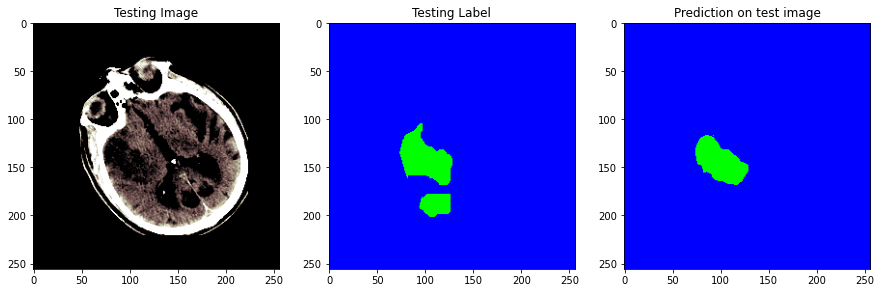

In [ ]:

img_test = mySet.testArrayX[num_img_test]
test_label = mySet.testArrayY[num_img_test]

img_test_input = np.expand_dims(img_test, 0)

pred = ((model.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8)
'''pred2 = ((att_unet_model2.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8)
pred3 = ((att_unet_model3.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8)
pred4 = ((att_unet_model4.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8)
pred5 = ((att_unet_model5.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8)'''
#pred = (att_unet_model.predict(img_test_input)[0,:,:,0] > 0.5).astype(np.uint8)
#pred2 = (att_unet_model.predict(img_test_input)[0,:,:,1] > 0.5).astype(np.uint8)
# Visualize the result 
plt.figure(figsize=(15, 10))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(img_test, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_label[:,:,:], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(pred, cmap='gray')


num_img_test+=1

# MODEL 8

In [ ]:
model_Unet = models.unet_2d((256, 256, 3), filter_num=[64, 128, 256, 512, 1024], 
                           n_labels=3, 
                           stack_num_down=2, stack_num_up=2, 
                           activation='ReLU', 
                           output_activation='Softmax', 
                           batch_norm=True, pool=False, unpool=False, 
                           backbone='VGG16', weights='imagenet', 
                           freeze_backbone=True, freeze_batch_norm=True, 
                           name='unet')

/usr/local/lib/python3.7/dist-packages/keras_unet_collection/_backbone_zoo.py:45: UserWarning: 

Backbone VGG16 does not use batch norm, but other layers received batch_norm=True
  warnings.warn(param_mismatch);


58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
model_Unet.load_weights("/content/drive/MyDrive/sotaSegMod/model_Unet2D.h5")

In [ ]:
from keras_unet_collection.losses import iou_seg

model_Unet.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy',iou_seg])


In [ ]:
checkpoint_filepath="/content/drive/MyDrive/sotaSegMod/model_Unet2D.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_iou_seg',
    mode='min',
    save_best_only=True)



In [ ]:
history = model_Unet.fit(mySet.trainingArrayX, mySet.trainingArrayY, 
                             verbose=1,
                             batch_size = 32,
                             validation_data=(mySet.testArrayX,mySet.testArrayY),
                             shuffle=False,
                             epochs=200,
                             callbacks=[model_checkpoint_callback])

In [ ]:
for i in range(len(mySet.nameArray)):
  img_test = mySet.testArrayX[i]
  img_test_input = np.expand_dims(img_test, 0)
  plt.imsave("/content/testFolder/"+str(mySet.nameArray[i]),(((model.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8)))

# MODEL 9

In [ ]:
from keras_unet_collection import losses
model = models.att_unet_2d((256, 256, 3), filter_num=[64, 128, 256, 512, 1024], n_labels=2, 
                           stack_num_down=4, stack_num_up=2, activation='ReLU', 
                           atten_activation='ReLU', attention='add', output_activation='Sigmoid', 
                           batch_norm=True, pool=True, unpool=False, 
                           backbone='VGG16', weights='imagenet', 
                           freeze_backbone=False, freeze_batch_norm=False, 
                           name='attunet')

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr = 1e-3), 
              metrics=['accuracy', losses.dice_coef,losses.iou_seg])

/usr/local/lib/python3.7/dist-packages/keras_unet_collection/_backbone_zoo.py:45: UserWarning: 

Backbone VGG16 does not use batch norm, but other layers received batch_norm=True
  warnings.warn(param_mismatch);
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
help(models.att_unet_2d)

In [ ]:
checkpoint_filepath="/content/drive/MyDrive/collectionModels/attUnet.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_iou_seg',
    mode='min',
    save_best_only=True)



In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
history = model_att_unet.fit(mySet.trainingArrayX, mySet.trainingArrayY, 
                             verbose=1,
                             batch_size = 32,
                             validation_data=(mySet.testArrayX,mySet.testArrayY),
                             shuffle=True,
                             epochs=100,
                             callbacks=[model_checkpoint_callback])

In [ ]:
for i in range(len(mySet.nameArray)):
  img_test = mySet.testArrayX[i]
  img_test_input = np.expand_dims(img_test, 0)
  plt.imsave("/content/testFolder/"+str(mySet.nameArray[i]),(((model_att_unet.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8)))

# MODEL 10

In [ ]:
from keras_unet_collection import models,utils
import numpy as np
from glob import glob
from tensorflow import keras 
from keras_unet_collection.losses import iou_seg,dice_coef
from keras import backend as K

In [ ]:
model = models.unet_2d((256, 256, 3), [512,1024], n_labels=3,
                      stack_num_down=2, stack_num_up=1,
                      activation='GELU', output_activation='Softmax', 
                      batch_norm=True, pool='max', unpool='nearest', name='unet')

In [ ]:
model.summary()

In [ ]:
focal_loss = sm.losses.CategoricalCELoss()

adam=tf.keras.optimizers.Adam(0.00005)
metric = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
model.compile(loss=focal_loss, optimizer=adam, 
              metrics=metric)

In [ ]:
model.load_weights("/content/drive/MyDrive/collectionModels/augmentModeladam.h5")

In [ ]:
checkpoint_filepath="/content/drive/MyDrive/collectionModels/enerjik.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_iou_score',
    mode='max',
    save_best_only=True)


In [ ]:
history = model.fit(mySet.trainingArrayX, mySet.trainingArrayY, 
                             verbose = 1,
                             batch_size = 4,
                             validation_data = (mySet.testArrayX,mySet.testArrayY),
                             shuffle = False,
                             epochs = 25,
                             callbacks = [model_checkpoint_callback])

In [ ]:
from matplotlib import pyplot as plt
import cv2
for i in range(len(mySet.nameArray)):
  img_test = mySet.testArrayX[i]
  img_test_input = np.expand_dims(img_test, 0)
  plt.imsave("/content/testFolder/"+str(mySet.nameArray[i]),cv2.cvtColor(((model.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8),cv2.COLOR_BGR2RGB))

In [ ]:
modelTwo = models.unet_2d((256, 256, 3), [64, 128, 256, 512, 1024], n_labels=3,
                      stack_num_down=2, stack_num_up=2,
                      activation='ReLU', output_activation='Softmax', 
                      batch_norm=True, pool='max', unpool='nearest', name='unet')

In [ ]:
modelTwo.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), 
              metrics=[dice_coef,iou_seg])

In [ ]:
modelTwo.load_weights("/content/drive/MyDrive/collectionModels/unetReluOne.h5")

# MODEL 11

In [ ]:
!pip install -U segmentation-models

In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [ ]:
import keras
import tensorflow as tf
print(keras.__version__)
print(tf.__version__)
#from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
from segmentation_models.losses import cce_jaccard_loss
from segmentation_models.metrics import iou_score

2.6.0
2.6.0


In [ ]:
from tensorflow.keras.layers import Input,Conv2D,Rescaling
from tensorflow.keras import Model
base_model = sm.Unet('vgg16', classes=3, activation='softmax',encoder_weights='imagenet',decoder_use_batchnorm=True)
inp = Input(shape=(None, None, 1))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels

out = base_model(l1)


model = Model(inp, out, name=base_model.name)
#model=base_model

In [ ]:
model.load_weights("/content/drive/MyDrive/SegmentModelLastDay/vgg256unetilkoturum.h5")

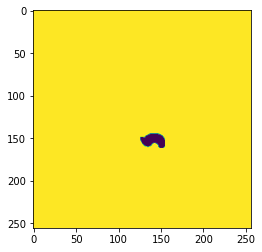

In [ ]:
plt.imshow(mySet.trainingArrayY[0][:,:,0])

In [ ]:
#model.load_weights('/content/drive/MyDrive/ModelsForCompetition/mehmetakifgece.h5')

dice_loss = sm.losses.DiceLoss(class_indexes=np.array([0,1])) 
focal_loss = sm.losses.CategoricalCELoss(class_indexes=np.array([0,1]))
jaccard_loss=sm.losses.JaccardLoss(class_indexes=np.array([0,1]))
total_loss = 0.5*dice_loss + 0.25*jaccard_loss + 0.25*focal_loss
adam=tf.keras.optimizers.Adam(learning_rate=0.0001) 
metrics = [sm.metrics.IOUScore(threshold=0.5,class_indexes=np.array([0,1])),sm.metrics.FScore(threshold=0.5,class_indexes=np.array([0,1]))]
model.compile(optimizer=adam,loss=dice_loss,metrics=metrics)

In [ ]:
model.load_weights('/content/drive/MyDrive/SegmentModelLastDay/vgg256unetilkoturum.h5')

In [ ]:
model_json = model.to_json()
with open("/content/drive/MyDrive/SegmentationLastModels/modelResNetFocalTwo.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/SegmentationLastModels/modelResNetFocalTwo.h5")
print("Saved model to disk")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Saved model to disk


In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/SegmentModelLastDay/vgg256focalilkoturumiki.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_iou_score',
    mode='max',
    save_best_only=True,
    save_weights_only=True)


In [ ]:
model.fit(
   x=mySet.trainingArrayX,
   y=mySet.trainingArrayY,
   batch_size=2,
   epochs=200,
   validation_data=(mySet.testArrayX, mySet.testArrayY),
   callbacks=[model_checkpoint_callback],
)

In [ ]:
vmodel.fit(
   x=mySet.trainingArrayX,
   y=mySet.trainingArrayY,
   batch_size=4,
   epochs=100,
   validation_data=(mySet.testArrayX, mySet.testArrayY),
   callbacks=[model_checkpoint_callback],
)

In [ ]:
for i in range(len(mySet.nameArray)):
  img_test = mySet.testArrayX[i]
  img_test_input = np.expand_dims(img_test, 0)
  plt.imsave("/content/testFolder/"+str(mySet.nameArray[i]),((model.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8))

In [ ]:
model.save_weights("/content/drive/MyDrive/SegmentModelLastDay/79verenmodelsonepoch.h5")

# Evaluation

In [ ]:
from keras.models import model_from_json
json_file = open('/content/drive/MyDrive/SegmentationLastModels/modelResNetFocalTwo.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/SegmentationLastModels/modelResNetFocalTwo.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
#model.load_weights('/content/drive/MyDrive/ModelsForCompetition/mehmetakifgece.h5')
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 1, 0.5])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = (0.75 * dice_loss) + (0.25 * focal_loss)
adam=tf.keras.optimizers.Adam(0.0001)
metrics = [sm.metrics.IOUScore(threshold=0.5),sm.metrics.FScore(class_indexes=np.array([0,1]),threshold=0.5)]
loaded_model.compile(optimizer=adam,loss=total_loss,metrics=metrics)

In [ ]:
model.evaluate(mySet.testArrayX,mySet.testArrayY)

14/14 [==============================] - 11s 391ms/step - loss: 0.2218 - iou_score: 0.7531 - f1-score: 0.8358


[0.22175036370754242, 0.7531320452690125, 0.8358188271522522]

In [ ]:
import tensorflow as tf
import numpy as np
coefList=[]
lenlist=[]
reals,preds,preds2=[],[],[]
for i in range(len(mySet.nameArray)):
   
  predimg=cv2.imread("/content/drive/MyDrive/Segment/BoneNewTwo/TestSet/Annotation/"+mySet.nameArray[i])
  reals.append(predimg)
  predimgOne=predimg[:,:,0:2]
  realimg=cv2.resize(cv2.imread("/content/testFolder/"+mySet.nameArray[i]),(512,512),interpolation=cv2.INTER_CUBIC)
  realimg2=cv2.resize(cv2.imread("/content/testFolder/"+mySet.nameArray[i]),(512,512),interpolation=cv2.INTER_NEAREST)
  preds.append(realimg)
  preds2.append(realimg2)
  realimgOne=realimg2[:,:,0:2]
  predimgOneF=predimgOne.flatten()
  realimgOneF=realimgOne.flatten()
  intersectOne=predimgOneF*realimgOneF
  intersectOne=np.sum(intersectOne)

  xorOne=np.sum(np.logical_xor(predimgOneF,realimgOneF))
  iouOne=intersectOne/(intersectOne+xorOne)
  coefList.append(iouOne)

In [ ]:
sum(coefList)/len(coefList)

0.5241832048825514

In [ ]:
import tensorflow as tf
import numpy as np
coefList=[]
lenlist=[]
reals,preds,preds2=[],[],[]
for i in range(len(mySet.nameArray)):
   
  predimg=cv2.imread("/content/drive/MyDrive/Segment/BoneNewTwo/TestSet/Annotation/"+mySet.nameArray[i])
  reals.append(predimg)
  predimgOne=predimg[:,:,0:2]
  realimg=cv2.cvtColor(cv2.imread("/content/testFolder/"+mySet.nameArray[i]),cv2.COLOR_BGR2RGB)
  realimg2=cv2.imread("/content/testFolder/"+mySet.nameArray[i])
  preds.append(realimg)
  preds2.append(realimg2)
  realimgOne=realimg[:,:,0:2]
  predimgOneF=predimgOne.flatten()
  realimgOneF=realimgOne.flatten()
  intersectOne=predimgOneF*realimgOneF
  intersectOne=np.sum(intersectOne)

  xorOne=np.sum(np.logical_xor(predimgOneF,realimgOneF))
  iouOne=intersectOne/(intersectOne+xorOne)
  coefList.append(iouOne)

In [ ]:
sum(coefList)/len(coefList)

0.5855659877878219

In [ ]:
import time
scores=[]

for i in range(len(mySet.nameArray)):
    start = time.time()
   
    
    grd=cv2.cvtColor(cv2.imread("/content/drive/MyDrive/Segment/BoneNewTwo/TestSet/Annotation/"+mySet.nameArray[i]),cv2.COLOR_BGR2RGB)
    prd=cv2.cvtColor(cv2.resize(cv2.imread("/content/testFolder/"+mySet.nameArray[i]),(512,512),interpolation=cv2.INTER_CUBIC),cv2.COLOR_BGR2RGB)
    newimage=np.zeros((512,512))
    newimage2=np.zeros((512,512))
    for i in range(512):
      for j in range(512):
        class_labels = np.argmax(prd[i,j], axis=0)
        newimage[i][j]=class_labels
        class_labelsTwo = np.argmax(grd[i,j], axis=0)
        newimage2[i][j]=class_labelsTwo
    predictedMask=newimage
    groundtruthMask=newimage2
    
    iou=calculateIoU(groundtruthMask,predictedMask,False)
    end = time.time()
  
    scores.append(iou)
    print(end - start,iou,sum(scores)/len(scores))

In [ ]:
sum(scores)/len(scores)

0.695549726698729

In [ ]:
scores=[]
for i in range(len(mySet.nameArray)):

    prd=cv2.imread("/content/drive/MyDrive/Segment/BoneNewTwo/TestSet/Annotation/"+mySet.nameArray[i])
    grd=cv2.resize(cv2.imread("/content/testFolder/"+mySet.nameArray[i]),(512,512),interpolation=cv2.INTER_CUBIC)
    newimage=np.zeros((512,512))
    newimage2=np.zeros((512,512))
    for i in range(512):
      for j in range(512):
        if prd[i][j][0]==255:
          newimage[i][j]=1
        if prd[i][j][1]==255:
          newimage[i][j]=2
        if prd[i][j][2]==255:
          newimage[i][j]=0
        if grd[i][j][0]==255:
          newimage2[i][j]=1
        if grd[i][j][1]==255:
          newimage2[i][j]=2
        if grd[i][j][2]==255:
          newimage2[i][j]=0
    predictedMask=newimage
    groundtruthMask=newimage2
    
    iou=calculateIoU(groundtruthMask,predictedMask,False)
    print(iou)
    scores.append(iou)


In [ ]:
sum(scores)/len(scores)

0.7188215406567501

In [ ]:

newimage=np.zeros((512,512))
for i in range(len(prd[0])):
  print(prd[0][i])
  if prd[0][i][0]==255:
    newimage[i][i]=0
  if prd[0][i][1]==255:
    newimage[i][j]=1
  if prd[0][i][2]==255:
    newimage[i][j]=2
  
plt.imshow(newimage)

In [ ]:
def loadMask(path):
    reader = sitk.ImageFileReader()
    reader.SetFileName(path)
    sitkMask = reader.Execute();
    mask = sitk.GetArrayFromImage(sitkMask)
    
    return mask

def showGrayScale(mask, title):
    plt.imshow(mask, cmap=plt.cm.gray)
    plt.title(title)
    plt.show()

# 8 bit ve tek kanallı, normal (0), iskemik (1) ve kanama (2) sınıflarından oluşan
# groundTruthMask ve predictedMask'i parametre olarak alip predictedMask'i puanlayan fonksiyon.
# Maskelerin her adımdakı değişiminlerini görmek için showSteps = True.
def calculateIoU(groundTruthMask, predictedMask, showSteps = False):
    
    if showSteps:
        showGrayScale(groundtruthMask, "Ground Truth Maskesi")
        showGrayScale(predictedMask, "Predicted Maskesi")
    
    # 1 ve 2 maskelerini ayrı ayrı oluşturuyoruz (0 ve 255 değerlerinin olduğu birer maske olarak)
    mask1 = np.where(groundtruthMask == 1, 1, 0).astype(np.uint8)
    mask2 = np.where(groundtruthMask == 2, 1, 0).astype(np.uint8)
    

    if showSteps:
        showGrayScale(mask1, "Ground Truth Sınıf 1")
        showGrayScale(mask2, "Ground Truth Sınıf 2")
        

    # İki sınıfı ayrı ayrı dilate ve erode ediyoruz
    kernel = np.ones((3,3))

    erosion1 = cv2.erode(mask1, kernel, iterations=1) 
    dilation1 = cv2.dilate(mask1, kernel, iterations=1)

    erosion2 = cv2.erode(mask2, kernel, iterations=1) 
    dilation2 = cv2.dilate(mask2, kernel, iterations=1)
    
   
    if showSteps:
        showGrayScale(erosion1, "Erode Edilmiş Ground Truth Sınıf 1")
    
    
    # Erode edilmiş ground truth class maskelerini birleştiriyoruz
    erodedGroundtruth = np.zeros(groundtruthMask.shape, dtype = np.uint8)
    erodedGroundtruth[erosion1 == 1] = 1
    erodedGroundtruth[erosion2 == 1] = 2
    
    
    if showSteps:
        showGrayScale(erodedGroundtruth, "Erode Edilmiş Ground Truthların Birleştirilmesi")
    
    
    # Dilate edilmiş ground truth class maskelerini birleştiriyoruz
    dilatedGroundtruth = np.zeros(groundtruthMask.shape, dtype = np.uint8)
    dilatedGroundtruth[dilation1 == 1] = 1
    dilatedGroundtruth[dilation2 == 1] = 2    
    
    
    if showSteps:
        showGrayScale(dilatedGroundtruth, "Dilate Edilmiş Ground Truthların Birleştirilmesi")
    
    
    # Dilate edilmiş ground truth ile kesişim
    intersection = np.where(np.logical_and(dilatedGroundtruth == predictedMask, dilatedGroundtruth != 0), 1, 0)        
    intersectionCount = np.count_nonzero(intersection)

    # Erode edilmiş ground truth ile birleşim
    union = np.where(np.logical_or(erodedGroundtruth != 0, predictedMask != 0), 1, 0)
    unionCount = np.count_nonzero(union)

    score = intersectionCount / unionCount

    
    if showSteps:
        showGrayScale(intersection, "Kesişim")
        showGrayScale(union, "Birleşim")
        print('Kesişim piksel sayısı: ', intersectionCount)
        print('Birleşim piksel sayısı: ', unionCount)
        print('Puan: ', score)
    
    
    return score

In [ ]:
num_img_test=27

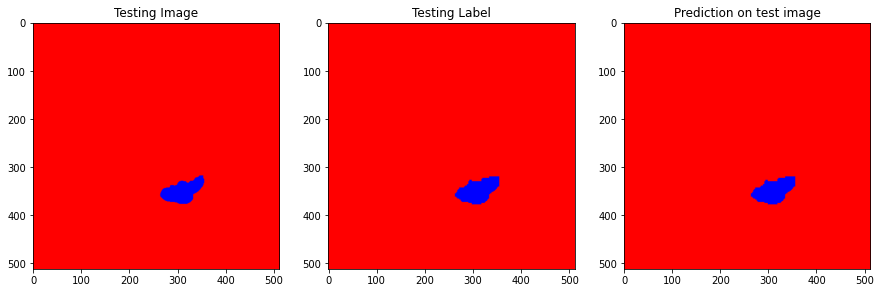

In [ ]:

img_test = reals[num_img_test]
test_label = preds2[num_img_test]
pred = preds[num_img_test]
'''pred2 = ((att_unet_model2.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8)
pred3 = ((att_unet_model3.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8)
pred4 = ((att_unet_model4.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8)
pred5 = ((att_unet_model5.predict(img_test_input)[0,:,:,:] > 0.5)*255).astype(np.uint8)'''
#pred = (att_unet_model.predict(img_test_input)[0,:,:,0] > 0.5).astype(np.uint8)
#pred2 = (att_unet_model.predict(img_test_input)[0,:,:,1] > 0.5).astype(np.uint8)
# Visualize the result 
plt.figure(figsize=(15, 10))
plt.subplot(231)

plt.title('Testing Image')
plt.imshow(img_test, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_label[:,:,:], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(pred, cmap='gray')

num_img_test+=1

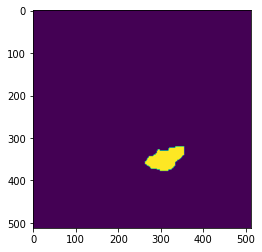

In [ ]:
plt.imshow(test_label[:,:,2])

In [ ]:
cv2.resize(imgm,(512,512),interpolation=cv2.INTER_NEAREST)

# Upload

In [ ]:
!pip install pydicom

In [ ]:
import pngGeneratorTwo
gen=pngGeneratorTwo.PngGenerator("/content/drive/MyDrive/TRAINING/INMEYOK/DICOM")
gen.insertDicomData()
len(gen.pathList)

4427

In [ ]:
gen.getPngData("/content/drive/MyDrive/CubicData","Inmeyok")

# WORKING CODE

In [ ]:
!pip install pydicom

In [ ]:
from PIL import Image
import numpy as np
from numpy import asarray
import cv2
import tensorflow as tf
import os
from tensorflow.keras.models import model_from_json
from tensorflow.keras.utils import to_categorical
import pandas as pd

In [ ]:
import yarismaPngGenerator
pngGen=yarismaPngGenerator.PngGenerator("/content/drive/MyDrive/yarismaOturumBir","Classification")
pngGen.insertDicomData()
pngGen.getPngData("/content/drive/MyDrive/pngOturumBir","Data")

In [ ]:
# Import necessary components to build LeNet

from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout
import numpy as np
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.efficientnet import EfficientNetB5
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.vgg19 import VGG19
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import l2
import numpy as np
from keras import layers
from keras.layers import Input, Dense,Dropout, Activation,BatchNormalization, Flatten, Conv2D, MaxPooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from keras.callbacks import EarlyStopping
from keras.layers import Dense, GlobalAveragePooling2D

from keras.layers import Dense, GlobalAveragePooling2D

def vgg16():
    
  conv=VGG16(input_shape=[224,224,3],weights='imagenet',include_top=False)
  conv.output


  x = conv.output
  x = Dropout(0.2)(x)
  x = GlobalAveragePooling2D()(x)


  x = Dense(2048,activation='relu')(x)
  x = Dense(1024,activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(1024,activation='relu')(x)
  x = Dense(512,activation='relu')(x)
  
  
  pred = Dense(2,activation='softmax')(x)
  model = Model(inputs = conv.input,outputs=pred)

  model.summary()


  for layer in conv.layers:
      layer.trainable = False
  return model
model=vgg16()

In [ ]:
adam=tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = adam ,loss="categorical_crossentropy", metrics=['accuracy'])
model.load_weights("/content/drive/MyDrive/SagliktaYapayZekaModelleri/modelAugmented.h5")

In [ ]:
filenamelist

In [ ]:
liste=list()
liste2=list()
filenamelist=list()
path="/content/drive/MyDrive/pngOturumBir"
predictions=[]
for subdir,dirs,files in os.walk(path):
  for file in files:
    filePath=subdir+os.sep+file
    img=cv2.imread(filePath)
    img_test = cv2.resize(img,(224,224),interpolation=cv2.INTER_CUBIC)
    liste.append(img_test)
    liste2.append(0)
    img_test_input = np.expand_dims(img_test,0)
    img_test_input=img_test_input.astype(np.float32)
    img_test_input=img_test_input/255.
    strfile=file
    filenamelist.append(strfile.split(".")[0])

    prediction = model.predict(img_test_input)
    prediction=(prediction>0.5).astype(np.uint8)
    predictions.append(prediction)



In [ ]:
preds=list()

for i in range(len(predictions)):
  preds.append(int(predictions[i][0][1]))


In [ ]:
import pandas as pd

data={
    "ID": filenamelist,
    "ETİKET": preds
}

df=pd.DataFrame(data)
df = df.reset_index(drop=True)

csv=df.to_csv("/content/drive/MyDrive/OTURUM1.csv",index=False)

df

In [ ]:
listeyeni=list()
for i in pngGen.pathList:
 spltd=i.split(os.sep)[-1]
 spltdtwo=spltd.split(".")[0]
 if spltdtwo not in filenamelist:
   listeyeni.append(spltdtwo)


In [ ]:
listeyeni

['11074']